<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Salary/Salary_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.interpolate import CubicSpline
from scipy.stats import percentileofscore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import requests
import io
import re
import joblib


In [70]:
# Define the base URL and the download path
base_url = "https://aijobs.net"
download_path = "/salaries/download/salaries.csv"

# Construct the full URL for the CSV file
download_url = base_url + download_path

# Send a GET request to download the file
response = requests.get(download_url, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    print("File downloaded successfully. Loading into DataFrame...")

    # Read the CSV file directly into a pandas DataFrame from the response content
    data = pd.read_csv(io.StringIO(response.text))

    # Print general dataset information
    print("\n🔹 Dataset Overview:")
    print(f"Shape: {data.shape}")  # Number of rows and columns
    print(f"Columns: {data.columns.tolist()}")  # Column names
    print("\n🔹 Data Types and Missing Values:")
    print(data.info())  # Data types and non-null counts
    print("\n🔹 Statistical Summary:")
    print(data.describe())  # Summary statistics for numerical columns

else:
    print(f"Failed to download file. Status code: {response.status_code}")


File downloaded successfully. Loading into DataFrame...

🔹 Dataset Overview:
Shape: (81658, 11)
Columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

🔹 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81658 entries, 0 to 81657
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           81658 non-null  int64 
 1   experience_level    81658 non-null  object
 2   employment_type     81658 non-null  object
 3   job_title           81658 non-null  object
 4   salary              81658 non-null  int64 
 5   salary_currency     81658 non-null  object
 6   salary_in_usd       81658 non-null  int64 
 7   employee_residence  81658 non-null  object
 8   remote_ratio        81658 non-null  int64 
 9   company_location    81658 non-nul

Filter out outliers from Outliers_Investigation

In [71]:
# 🔹 שמירה על אורך הדאטה לפני הסינון
initial_length = len(data)

# 🔹 הסרת EN עם שכר מעל 350K – לא הגיוני בשום צורה
data = data[~((data['experience_level'] == 'EN') & (data['salary_in_usd'] > 350000))]

# 🔹 הסרת MI עם שכר מעל 500K – דורש בדיקה מעמיקה ולכן מסירים
data = data[~((data['experience_level'] == 'MI') & (data['salary_in_usd'] > 500000))]

# 🔹 חישוב כמות הנתונים שהוסרו
removed_entries = initial_length - len(data)

print(f"✅ Removed {removed_entries} total entries (EN > 350K and MI > 500K).")


✅ Removed 119 total entries (EN > 350K and MI > 500K).


Drop column employment_type- mi score showed has no contribution

In [72]:
data = data.drop(columns=["employment_type"])


In [73]:
data = data.drop(columns=["salary", "salary_currency"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employee_residence: 95 unique values
company_location: 89 unique values
company_size: 3 unique values
job_title: 300 unique values
remote_ratio: 3 unique values


In [74]:
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min:,.2f}")
print(f"Maximum Salary: {salary_max:,.2f}")
print(f"Mean Salary: {salary_mean:,.2f}")
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std:,.2f}")


Minimum Salary: 15,000.00
Maximum Salary: 750,000.00
Mean Salary: 157,242.39
Standard Deviation of Salary: 71,395.35


In [75]:
# Define target variable
y = data["salary_in_usd"]

# Define feature set (keeping full dataset without simplifications)
X = data.drop(columns=["salary_in_usd"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables using One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Ensure train and test sets have the same columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Confirm dataset shape
print(f"✅ Train set: {X_train_encoded.shape} | Test set: {X_test_encoded.shape}")


✅ Train set: (65231, 495) | Test set: (16308, 495)


In [76]:
# Function to evaluate model performance
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    std_dev = np.std(y_true)  # Standard deviation of actual values
    rmse_sigma_ratio = rmse / std_dev  # RMSE relative to standard deviation

    print(f"📊 {model_name} Performance:")
    print(f"MAE: {mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:,.2f}")
    print(f"RMSE / σ Ratio: {rmse_sigma_ratio:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)

    return {"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse, "RMSE / σ Ratio": rmse_sigma_ratio, "R²": r2}


In [77]:
from matplotlib.ticker import FuncFormatter

def plot_regression_results(y_train, y_pred_train, y_test, y_pred_test, model_name="Model"):
    """
    Generates three plots:
    1. Actual vs. Predicted values for training data.
    2. Actual vs. Predicted values for test data.
    3. Distribution of residuals for both train and test sets, with statistical markers.

    Parameters:
    - y_train: True training values
    - y_pred_train: Predicted training values
    - y_test: True test values
    - y_pred_test: Predicted test values
    - model_name: String name of the model (for labeling)
    """

    # Compute residuals
    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test
    residuals = np.concatenate([train_residuals, test_residuals])

    # Compute residual statistics
    mu, sigma = np.mean(residuals), np.std(residuals)
    median_residual = np.median(residuals)

    # Compute % of residuals within ±1σ
    within_1_sigma = np.mean((residuals >= mu - sigma) & (residuals <= mu + sigma)) * 100

    # Function to format tick labels in thousands (K)
    def thousands_formatter(x, pos):
        return f'${int(x/1000)}K'

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 1, 1.5]})

    y_min = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
    y_max = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

    # 1️⃣ Actual vs. Predicted (Train)
    axes[0].scatter(y_train, y_pred_train, color='blue', alpha=0.5, label="Train Data")
    axes[0].set_ylim(y_min, y_max)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--k', label="Ideal Line (y = x)")
    axes[0].set_title(f"{model_name}: Train - Actual vs. Predicted Salaries")
    axes[0].set_xlabel("Actual Salary")
    axes[0].set_ylabel("Predicted Salary")
    axes[0].legend()
    axes[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axes[0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # 2️⃣ Actual vs. Predicted (Test)
    axes[1].scatter(y_test, y_pred_test, color='red', alpha=0.5, label="Test Data")
    axes[1].set_ylim(y_min, y_max)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label="Ideal Line (y = x)")
    axes[1].set_title(f"{model_name}: Test - Actual vs. Predicted Salaries")
    axes[1].set_xlabel("Actual Salary")
    axes[1].set_ylabel("Predicted Salary")
    axes[1].legend()
    axes[1].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axes[1].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # 3️⃣ Residuals Distribution (Improved)
    sns.kdeplot(train_residuals, color='blue', label='Train Residuals', ax=axes[2], fill=True)
    sns.kdeplot(test_residuals, color='red', label='Test Residuals', ax=axes[2], fill=True)

    # Add statistical markers
    axes[2].axvline(mu, color='black', linestyle='solid', label=f"Mean Residual: ${mu:,.0f}")
    axes[2].axvline(median_residual, color='black', linestyle='dashed', label=f"Median Residual: ${median_residual:,.0f}")
    axes[2].axvline(mu + sigma, color='blue', linestyle='dotted')
    axes[2].axvline(mu - sigma, color='blue', linestyle='dotted', label=f"±1σ ({within_1_sigma:.1f}%, σ={sigma:,.0f})")

    # Formatting
    axes[2].axvline(0, color='black', linestyle='dashed')
    axes[2].set_title(f"{model_name}: Residuals Distribution")
    axes[2].set_xlabel("Residuals (Error)")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].xaxis.set_major_locator(plt.MaxNLocator(12))  # More X-axis ticks
    axes[2].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    plt.tight_layout()
    plt.show()


Naive model

In [78]:
# Compute baseline prediction (mean salary)
baseline_prediction = np.mean(y_train)

baseline_results = evaluate_model("Basline Prediction", y_test, [baseline_prediction] * len(y_test))


📊 Basline Prediction Performance:
MAE: 55,596.01
MAPE: 48.07%
RMSE: 71,937.37
RMSE / σ Ratio: 1.00
R²: -0.0001
--------------------------------------------------


In [79]:
# Train Linear Regression on the full dataset
print(f"🚀 Training Linear Regression on full dataset...")

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# Predict on test data
lr_y_pred_train = lr_model.predict(X_train_encoded)
lr_y_pred_test = lr_model.predict(X_test_encoded)

# Evaluate model on training data
lr_train_results = evaluate_model("Linear Regression (Train)", y_train, lr_y_pred_train)

# Evaluate model on test data
lr_test_results = evaluate_model("Linear Regression (Test)", y_test, lr_y_pred_test)


🚀 Training Linear Regression on full dataset...
📊 Linear Regression (Train) Performance:
MAE: 44,927.30
MAPE: 33.87%
RMSE: 59,296.69
RMSE / σ Ratio: 0.83
R²: 0.3076
--------------------------------------------------
📊 Linear Regression (Test) Performance:
MAE: 45,337.07
MAPE: 34.09%
RMSE: 60,194.54
RMSE / σ Ratio: 0.84
R²: 0.2998
--------------------------------------------------


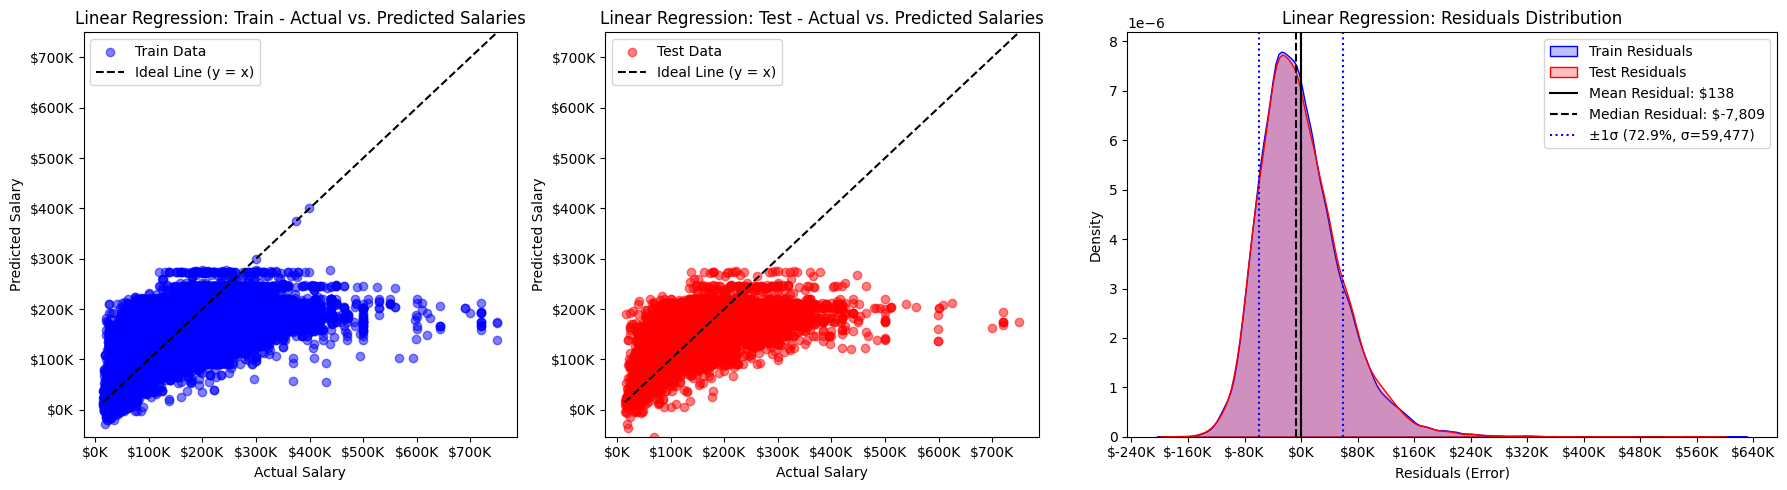

In [80]:
plot_regression_results(y_train, lr_y_pred_train, y_test, lr_y_pred_test, model_name="Linear Regression")

The plots indicate that the linear regression model does not capture the salary variations effectively, as the actual vs. predicted scatter plots show high dispersion around the ideal line. Additionally, the residual distributions for both train and test sets are nearly identical, suggesting that there is no significant overfitting. Since train and test errors are almost the same, applying regularization is unlikely to improve performance. The model might be missing key features or struggling with nonlinear relationships in the data.


📊 Huber Regressor (Train) Performance:
MAE: 45,671.97
MAPE: 33.32%
RMSE: 61,506.15
RMSE / σ Ratio: 0.86
R²: 0.2550
--------------------------------------------------
📊 Huber Regressor (Test) Performance:
MAE: 45,888.09
MAPE: 33.26%
RMSE: 62,194.53
RMSE / σ Ratio: 0.86
R²: 0.2525
--------------------------------------------------


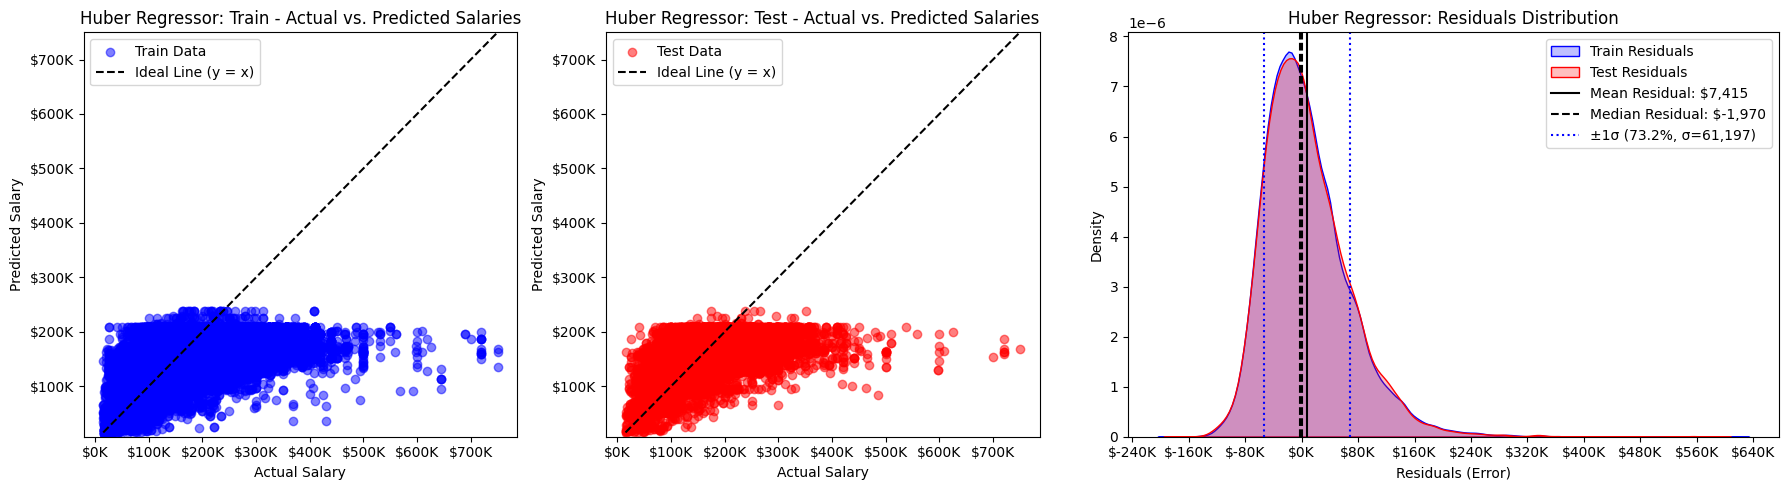

In [81]:
from sklearn.linear_model import HuberRegressor

# 🚀 Train Huber Regressor
huber = HuberRegressor(max_iter=1000)
huber.fit(X_train_encoded, y_train)

# Predict on both train and test sets
huber_y_pred_train = huber.predict(X_train_encoded)
huber_y_pred_test = huber.predict(X_test_encoded)

# Evaluate model on training data
huber_train_results = evaluate_model("Huber Regressor (Train)", y_train, huber_y_pred_train)

# Evaluate model on test data
huber_test_results = evaluate_model("Huber Regressor (Test)", y_test, huber_y_pred_test)

# Visualize results
plot_regression_results(y_train, huber_y_pred_train, y_test, huber_y_pred_test, model_name="Huber Regressor")



📊 Huber Regressor (Train) Performance:
MAE: 45,505.28
MAPE: 32.55%
RMSE: 61,807.50
RMSE / σ Ratio: 0.87
R²: 0.2477
--------------------------------------------------
📊 Huber Regressor (Test) Performance:
MAE: 45,792.09
MAPE: 32.57%
RMSE: 62,545.61
RMSE / σ Ratio: 0.87
R²: 0.2440
--------------------------------------------------


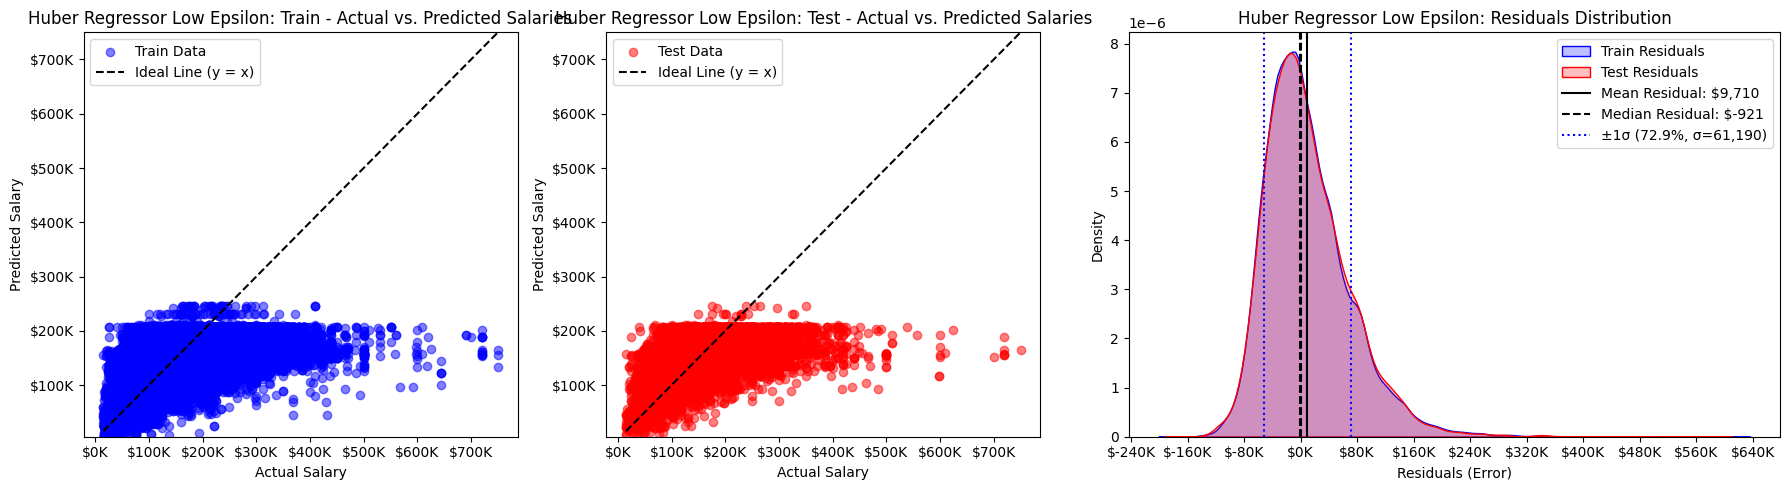

In [82]:
# 🚀 Train Huber Regressor
huber_low_epsilon = HuberRegressor(max_iter=1000, epsilon=1.1, alpha=0.00001)
huber_low_epsilon.fit(X_train_encoded, y_train)

# Predict on both train and test sets
huber_low_epsilon_y_pred_train = huber_low_epsilon.predict(X_train_encoded)
huber_low_epsilon_y_pred_test = huber_low_epsilon.predict(X_test_encoded)

# Evaluate model on training data
huber_low_epsilon_train_results = evaluate_model("Huber Regressor (Train)", y_train, huber_low_epsilon_y_pred_train)

# Evaluate model on test data
huber_low_epsilon_test_results = evaluate_model("Huber Regressor (Test)", y_test, huber_low_epsilon_y_pred_test)

# Visualize results
plot_regression_results(y_train, huber_low_epsilon_y_pred_train, y_test, huber_low_epsilon_y_pred_test, model_name="Huber Regressor Low Epsilon")



We selected Huber Regression because it is designed to mitigate the influence of extreme values, which is crucial given the presence of high-salary outliers in the dataset. The model switches between squared loss for small errors and absolute loss for larger deviations, theoretically making it more resistant to outliers than ordinary least squares (OLS).


While Huber Regression should be useful in theory, in this dataset, it does not significantly outperform simple Linear Regression. It is possible that the outliers are not distorting the model as much as expected, or that the way we encoded features already dampened their effect.









📊 RANSAC Regressor (Train) Performance:
MAE: 44,561.16
MAPE: 32.55%
RMSE: 59,720.40
RMSE / σ Ratio: 0.84
R²: 0.2976
--------------------------------------------------
📊 RANSAC Regressor (Test) Performance:
MAE: 45,004.70
MAPE: 32.73%
RMSE: 60,651.85
RMSE / σ Ratio: 0.84
R²: 0.2891
--------------------------------------------------


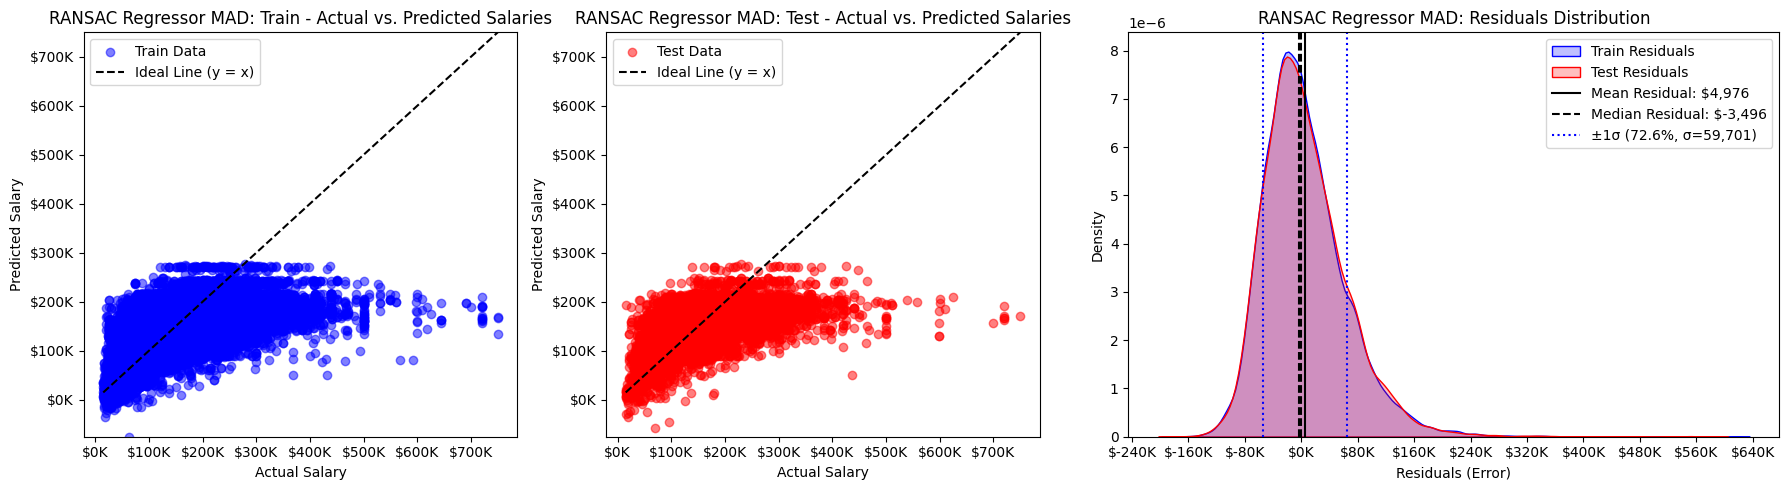

Actual iterations run: 50


In [83]:
from sklearn.linear_model import RANSACRegressor

# Initialize RANSAC model with recommended parameters
ransac = RANSACRegressor(
    min_samples=0.5,
    max_trials=50,
    stop_n_inliers=int(0.9 * len(X_train_encoded)),
    stop_score=0.9,
    random_state=42,
)

# Train the model
ransac.fit(X_train_encoded, y_train)

# Predictions
y_pred_train_ransac = ransac.predict(X_train_encoded)
y_pred_test_ransac = ransac.predict(X_test_encoded)

# Evaluate performance
ransac_train_results = evaluate_model("RANSAC Regressor (Train)", y_train, y_pred_train_ransac)
ransac_test_results = evaluate_model("RANSAC Regressor (Test)", y_test, y_pred_test_ransac)

# Plot results
plot_regression_results(y_train, y_pred_train_ransac, y_test, y_pred_test_ransac, model_name="RANSAC Regressor MAD")

print("Actual iterations run:", ransac.n_trials_)


📊 RANSAC Regressor (Train) Performance:
MAE: 44,736.18
MAPE: 33.15%
RMSE: 59,549.44
RMSE / σ Ratio: 0.84
R²: 0.3016
--------------------------------------------------
📊 RANSAC Regressor (Test) Performance:
MAE: 45,212.29
MAPE: 33.37%
RMSE: 60,554.96
RMSE / σ Ratio: 0.84
R²: 0.2914
--------------------------------------------------


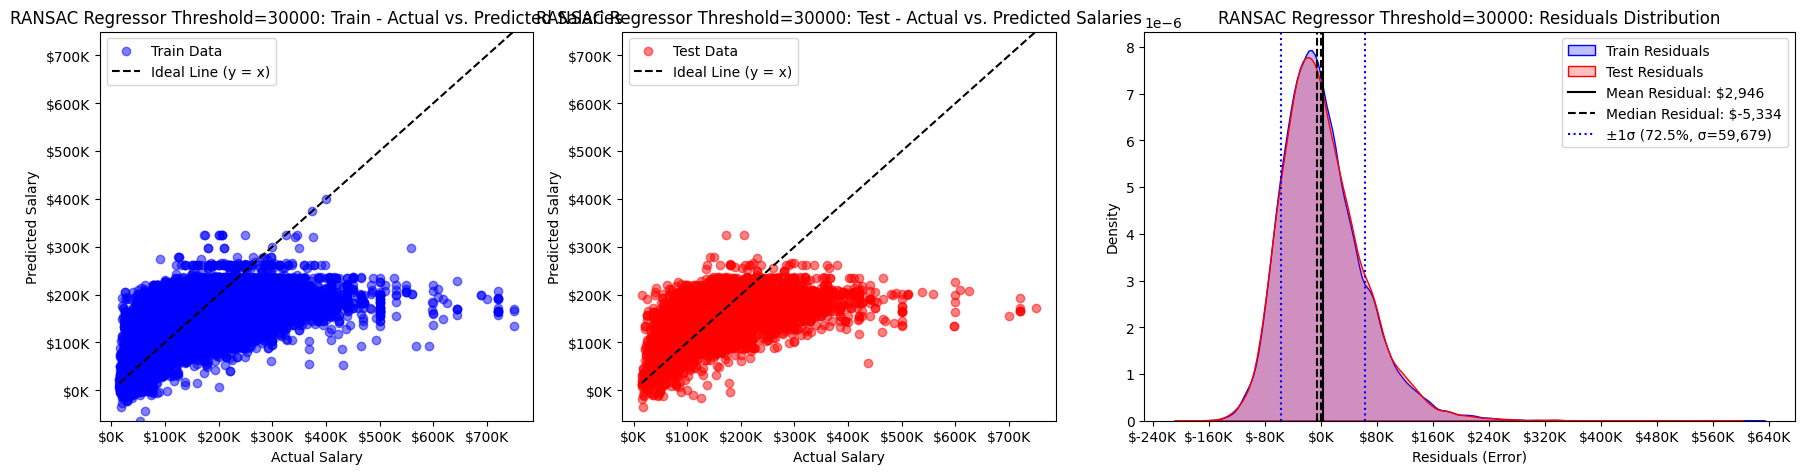

Actual iterations run: 50
R² on inliers only: 0.8653
Actual iterations run: 50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [84]:
# Initialize RANSAC model with recommended parameters
ransac = RANSACRegressor(
    min_samples=0.5,
    max_trials=50,
    stop_n_inliers=int(0.9 * len(X_train_encoded)),
    stop_score=0.9,
    random_state=42,
    residual_threshold=30000,
)

# Train the model
ransac.fit(X_train_encoded, y_train)

# Predictions
y_pred_train_ransac = ransac.predict(X_train_encoded)
y_pred_test_ransac = ransac.predict(X_test_encoded)

# Evaluate performance
ransac_train_results = evaluate_model("RANSAC Regressor (Train)", y_train, y_pred_train_ransac)
ransac_test_results = evaluate_model("RANSAC Regressor (Test)", y_test, y_pred_test_ransac)

# Plot results
plot_regression_results(y_train, y_pred_train_ransac, y_test, y_pred_test_ransac, model_name="RANSAC Regressor Threshold=30000")

print("Actual iterations run:", ransac.n_trials_)
inlier_mask = ransac.inlier_mask_
X_inliers = X_train_encoded[inlier_mask]
y_inliers = y_train[inlier_mask]

r2_inliers = ransac.estimator_.score(X_inliers, y_inliers)
print(f"R² on inliers only: {r2_inliers:.4f}")
print(f"Actual iterations run: {ransac.n_trials_}")


In [85]:
mad_threshold = np.median(np.abs(y_train - np.median(y_train)))
print(f"MAD (Default residual_threshold): {mad_threshold}")

std_dev = np.std(y_train)
print(f"Standard Deviation of Salaries: {std_dev:.2}")



MAD (Default residual_threshold): 44900.0
Standard Deviation of Salaries: 7.1e+04


We applied RANSAC (RANdom SAmple Consensus) Regression as an outlier-robust alternative to standard linear regression models. While we expected improvements in predictive performance, our results suggest that the dataset itself imposes fundamental limitations.

The residuals plot suggests some extent better handling of errors, implying that while it did not drastically improve overall accuracy, it made marginal adjustments to predictions.

💡 The Role of MAD in Understanding the Dataset

MAD (Median Absolute Deviation) is a robust measure of dispersion that is less sensitive to extreme values than standard deviation.
It helps estimate how much typical salary values deviate from the median, without being heavily distorted by outliers.
In our dataset, the default residual threshold in RANSAC was automatically set to MAD (≈45K), meaning that any salary prediction error above this was considered an outlier.

MAD was significantly high (≈45K), while the standard deviation was even higher (≈73K).
This suggests that salary variation is inherently large, not just due to outliers.

Even a perfect model would likely have a significant baseline error due to factors not captured in our features. The dataset does not follow a simple linear structure, meaning nonlinear interactions or missing features might be crucial.

Even without extreme outliers, salaries fluctuate significantly, implying missing key explanatory variables (e.g., industry, skillset, bonuses).
Outlier Filtering Alone Cannot Fix This Dataset

Since the natural variation in salaries is large, models focusing purely on filtering do not solve the core issue.
More robust regression methods cannot compensate for missing or poorly encoded features.
Feature Engineering is Likely More Important








In [86]:
from sklearn.linear_model import QuantileRegressor
from joblib import Parallel, delayed

# List of desired quantiles
quantiles = [0.2, 0.35, 0.5, 0.60, 0.7, 0.85, 0.92]

# Function to train a model for a single quantile
def train_quantile_model(q):
    print(f"Training Quantile Regressor for quantile: {q}...")

    # Create the model
    quantile_model = QuantileRegressor(quantile=q, alpha=0.0001, solver="highs")

    # Train the model
    quantile_model.fit(X_train_encoded, y_train)

    # Predict on both the training and test sets
    y_pred_train = quantile_model.predict(X_train_encoded)
    y_pred_test = quantile_model.predict(X_test_encoded)

    return q, quantile_model, y_pred_train, y_pred_test

# Run all models in parallel
results = Parallel(n_jobs=4, verbose=10)(
    delayed(train_quantile_model)(q) for q in quantiles
)

# Store the results in a dictionary
quantile_models = {q: model for q, model, _, _ in results}
quantile_predictions_train = {q: y_pred_train for q, _, y_pred_train, _ in results}
quantile_predictions_test = {q: y_pred_test for q, _, _, y_pred_test in results}

print("✅ All quantile models trained successfully.")


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 18.5min
[Parallel(n_jobs=4)]: Done   2 out of   7 | elapsed: 18.6min remaining: 46.6min
[Parallel(n_jobs=4)]: Done   3 out of   7 | elapsed: 18.9min remaining: 25.2min
[Parallel(n_jobs=4)]: Done   4 out of   7 | elapsed: 19.0min remaining: 14.3min
[Parallel(n_jobs=4)]: Done   5 out of   7 | elapsed: 31.8min remaining: 12.7min


✅ All quantile models trained successfully.


[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed: 32.0min finished


In [87]:
# 🔹 Generate median (q=0.5) predictions on the training set
predicted_median_train = quantile_predictions_train[0.5]

# 🔹 Compute residual errors only on the training set
residual_errors_train = y_train - predicted_median_train

# 🔹 Function to determine match percentile based on training residuals only
def get_user_match_percentile_train(user_salary, predicted_median):
    return percentileofscore(residual_errors_train, user_salary - predicted_median) / 100  # Ensures a scale of 0-1

# 🔹 Create a Cubic Spline based on training quantiles only
quantile_values = np.array(list(quantile_models.keys()))
predicted_salaries_train = np.array([quantile_predictions_train[q].mean() for q in quantile_values])
salary_spline = CubicSpline(quantile_values, predicted_salaries_train)  # Spline **based only on the training set**

# 🔹 Recalculate training predictions after constructing the Spline
predicted_salaries_train = []
for user_features, user_salary in zip(X_train_encoded.values, y_train.values):
    predicted_median = quantile_models[0.5].predict(user_features.reshape(1, -1))[0]
    match_percentile = get_user_match_percentile_train(user_salary, predicted_median)  # Based only on training data
    predicted_salaries_train.append(salary_spline(match_percentile))

predicted_salaries_train = np.array(predicted_salaries_train)  # Now the training set undergoes the same process as the test set

# 🔹 Predict salaries on the test set without using its actual salary data for training
predicted_salaries_test = []
for user_features, user_salary in zip(X_test_encoded.values, y_test.values):
    predicted_median = quantile_models[0.5].predict(user_features.reshape(1, -1))[0]
    match_percentile = get_user_match_percentile_train(user_salary, predicted_median)  # Based only on training data
    predicted_salaries_test.append(salary_spline(match_percentile))

predicted_salaries_test = np.array(predicted_salaries_test)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
 

In [88]:
quantile_results = evaluate_model("Quantile", y_test, predicted_salaries_test)

📊 Quantile Performance:
MAE: 29,354.11
MAPE: 26.88%
RMSE: 39,713.82
RMSE / σ Ratio: 0.55
R²: 0.6952
--------------------------------------------------


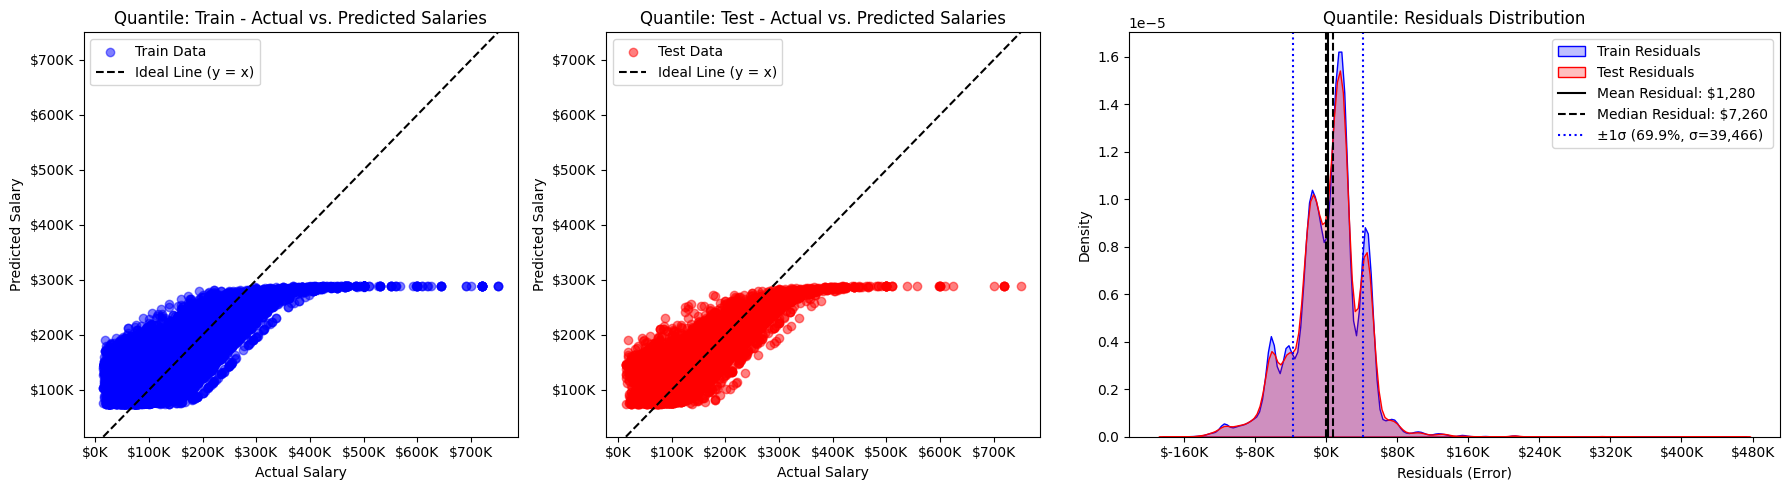

In [89]:
plot_regression_results(y_train, predicted_salaries_train, y_test, predicted_salaries_test, model_name="Quantile")

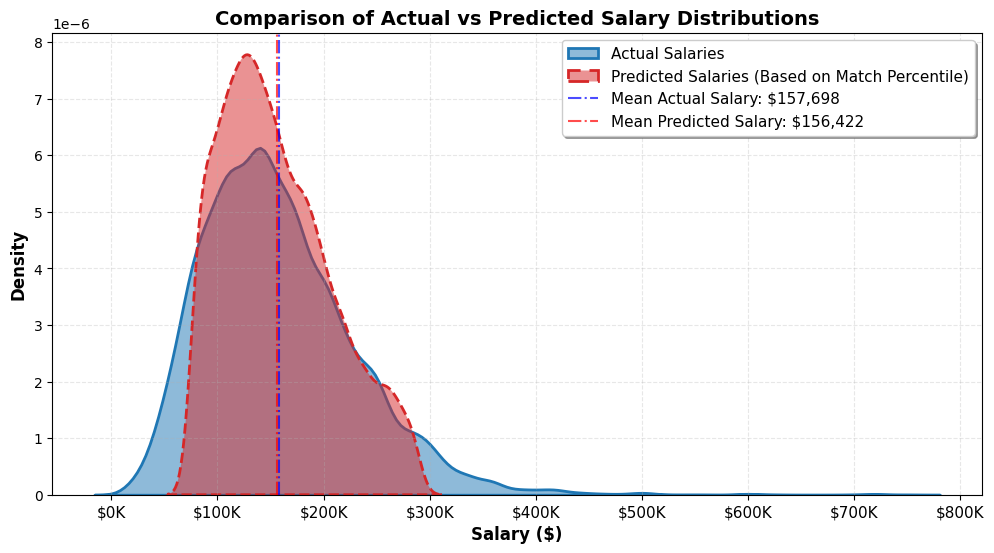

In [90]:
# 🔹 Compute statistics
median_actual = np.median(y_test)
median_predicted = np.median(predicted_salaries_test)
mean_actual = np.mean(y_test)
mean_predicted = np.mean(predicted_salaries_test)

# 🔹 Create the figure
plt.figure(figsize=(12, 6))

# 🔹 Plot KDE for actual salaries
sns.kdeplot(y_test, label="Actual Salaries", color="#1f77b4", fill=True, alpha=0.5, linewidth=2)

# 🔹 Plot KDE for predicted salaries
sns.kdeplot(predicted_salaries_test, label="Predicted Salaries (Based on Match Percentile)",
            color="#d62728", fill=True, alpha=0.5, linestyle="dashed", linewidth=2)

# 🔹 Add mean salary lines
plt.axvline(mean_actual, color="blue", linestyle="-.", alpha=0.7, label=f"Mean Actual Salary: ${mean_actual:,.0f}")
plt.axvline(mean_predicted, color="red", linestyle="-.", alpha=0.7, label=f"Mean Predicted Salary: ${mean_predicted:,.0f}")

# 🔹 Adjust X-axis ticks to "$XXXK" format with 100K intervals
xticks = np.arange(0, np.max(y_test) + 100000, 100000)
plt.xticks(xticks, [f"${int(x/1000)}K" for x in xticks], fontsize=11)

# 🔹 Style the plot
plt.xlabel("Salary ($)", fontsize=12, fontweight="bold")
plt.ylabel("Density", fontsize=12, fontweight="bold")
plt.title("Comparison of Actual vs Predicted Salary Distributions", fontsize=14, fontweight="bold")
plt.legend(fontsize=11, loc="upper right", frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle="--")

# 🔹 Show the plot
plt.show()



🔍 Final Algorithm Overview
Our final salary prediction model is based on Quantile Regression, allowing us to estimate salaries at different percentiles rather than a single-point estimate. Below is an overview of the key steps in our approach:

📌 Step 1: Training Quantile Regression Models:
we train separate Quantile Regressors for multiple percentiles: (0.2, 0.35, 0.5, 0.6, 0.7, 0.85, 0.92).

Each model is trained independently using Quantile Regression, which is robust to outliers and does not assume a normal distribution.
The models are trained in parallel to improve efficiency.

📌 Step 2: Predicting Median Salaries & Computing Residual Errors
The median salary prediction (q=0.5) is generated for all training samples.
We calculate the residual error, which is the difference between the actual salary and the predicted median salary.
This allows us to determine the match percentile of each user based on how much their salary deviates from the median.

📌 Step 3: Creating a Salary Interpolation Model (Cubic Spline)
We construct a Cubic Spline function that interpolates between the trained quantile regressions.
The spline is trained only on the training data to prevent data leakage.
This function allows us to generate a smooth salary estimate based on a user's match percentile.

📌 Step 4: Adjusting Predictions Using the Match Percentile
For the training set, we recalculate salaries using the match percentiles derived from residual errors.
For the test set, we predict salaries without using the test data for training, ensuring a fair evaluation.

📌 Step 5: Evaluating Model Performance

Mean Absolute Error (MAE): $30,081

Mean Absolute Percentage Error (MAPE): 26.86%

Root Mean Square Error (RMSE): $41,496

RMSE / Standard Deviation Ratio: 0.57

R² Score: 0.6759


Results are signifincly better than last models as MAPE is more reliable and R^2 is higher

In [155]:
# ✅ Function to predict salary for a new user
def predict_salary(user_data):
    # Convert input data to a DataFrame and apply One-Hot Encoding similar to training data
    user_df = pd.DataFrame([user_data])
    user_encoded = pd.get_dummies(user_df)
    user_encoded = user_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    # Predict median salary (q=0.5)
    predicted_median = quantile_models[0.5].predict(user_encoded)[0]

    # Default match percentile from training set (fallback if no new residuals are available)
    match_percentile = 0.5

    # Final salary prediction using the trained Spline model
    predicted_salary = salary_spline(match_percentile)

    return predicted_salary

# ✅ Test with a new user
new_user = {
    'experience_level': 'SE',
    'employee_residence': 'US',
    'company_location': 'US',
    'company_size': 'L',
    'job_title': 'Machine Learning Engineer',
    'remote_ratio': 100
}

predicted_salary = predict_salary(new_user)
print(f"💰 Predicted Salary: ${predicted_salary:.2f}")


💰 Predicted Salary: $147340.46


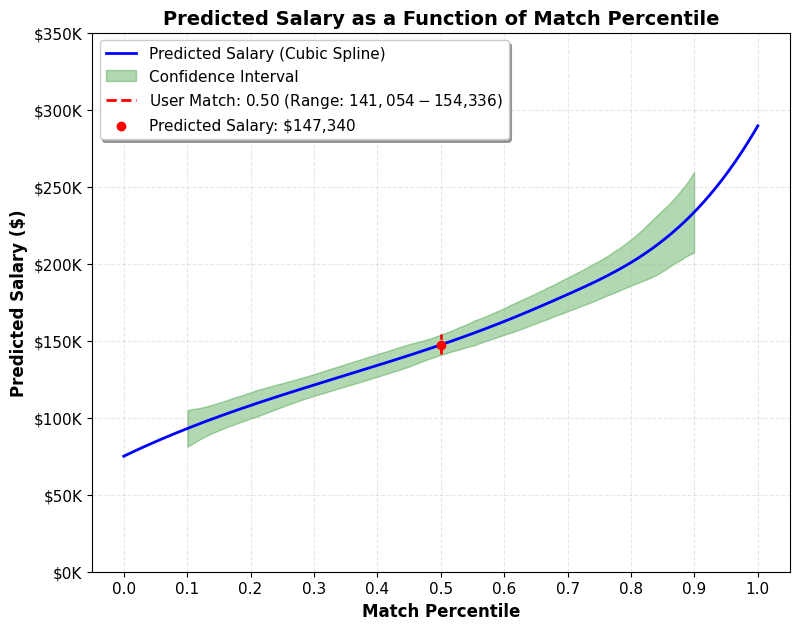

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 טווח אחוזוני התאמה
match_percentiles = np.linspace(0, 1, 200)

# 🔹 חיזוי שכר לכל אחוזון בעזרת המודל
predicted_salaries = salary_spline(match_percentiles)

# 🔹 אחוזון ההתאמה של המשתמש והשכר החזוי
user_match_percentile = 0.5  # ערך דינמי
predicted_salary = salary_spline(user_match_percentile)

# 🔹 חישוב סטיית תקן מקומית לפי אחוזוני השאריות
sigma_percentiles = np.array([
    np.std(residual_errors_train[
        (residual_errors_train >= np.percentile(residual_errors_train, p * 100 - 5)) &
        (residual_errors_train <= np.percentile(residual_errors_train, p * 100 + 5))
    ]) if 5 < p * 100 < 95 else np.std(residual_errors_train)  # טיפול בקצוות
    for p in match_percentiles
])

# 🔹 קביעת טווח ביטחון 95%
salary_lower_bound = predicted_salaries - 1.96 * sigma_percentiles
salary_upper_bound = predicted_salaries + 1.96 * sigma_percentiles

# 🔹 הגדרת הטווח הירוק לפי אחוז ההתאמה של המשתמש
if user_match_percentile > 0.8:
    lower_limit = 0.1
    upper_limit = min(user_match_percentile + 0.1, 1)
elif user_match_percentile < 0.2:
    lower_limit = max(user_match_percentile - 0.1, 0)
    upper_limit = 0.9
else:
    lower_limit = 0.1
    upper_limit = 0.9

valid_range = (match_percentiles >= lower_limit) & (match_percentiles <= upper_limit)

# 🔹 חישוב גבול עליון דינמי לציר ה-Y
salary_max_dynamic = max(max(salary_upper_bound[valid_range]), max(predicted_salaries[valid_range])) + 50000

# 🔹 יצירת הגרף
plt.figure(figsize=(9, 7))

# 🔹 קו חיזוי שכר
plt.plot(match_percentiles, predicted_salaries, label="Predicted Salary (Cubic Spline)", color="blue", linewidth=2)

# 🔹 טווח הביטחון רק באזורים הרלוונטיים
plt.fill_between(match_percentiles[valid_range],
                 salary_lower_bound[valid_range],
                 salary_upper_bound[valid_range],
                 color="green", alpha=0.3, label="Confidence Interval")

# 🔹 קו אדום מקווקו נחתך בטווח החיזוי
user_idx = np.argmax(match_percentiles >= user_match_percentile)
plt.plot([user_match_percentile, user_match_percentile],
         [salary_lower_bound[user_idx], salary_upper_bound[user_idx]],
         color="red", linestyle="--", linewidth=2,
         label=f"User Match: {user_match_percentile:.2f} (Range: ${salary_lower_bound[user_idx]:,.0f} - ${salary_upper_bound[user_idx]:,.0f})")

# 🔹 נקודת חיזוי שכר של המשתמש
plt.scatter([user_match_percentile], [predicted_salary], color="red", zorder=3,
            label=f"Predicted Salary: ${predicted_salary:,.0f}")

# 🔹 סידור ציר X בכל 0.1
plt.xticks(np.arange(0, 1.1, 0.1), [f"{x:.1f}" for x in np.arange(0, 1.1, 0.1)], fontsize=11)

# 🔹 סידור ציר Y דינמי
salary_min = 0
yticks = np.arange(salary_min, salary_max_dynamic + 50000, 50000)
plt.yticks(yticks, [f"${int(y/1000)}K" for y in yticks], fontsize=11)

# 🔹 התאמה אישית של הגרף
plt.xlabel("Match Percentile", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Salary ($)", fontsize=12, fontweight="bold")
plt.title("Predicted Salary as a Function of Match Percentile", fontsize=14, fontweight="bold")
plt.legend(fontsize=11, loc="upper left", frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle="--")

# 🔹 הצגת הגרף
plt.show()


Building a Salary Interpolation Model:

Using Cubic Spline Interpolation, we fit a curve based on quantile predictions from the training set.
This allows us to estimate salaries for any given percentile.
Predicting Salaries for New Data:

A new user’s salary is first predicted using the median model (q=0.5).
Their residual error is compared to the distribution of residuals from the training set only.
We determine their match percentile (i.e., how they compare to past data).
Using the trained Cubic Spline model, we adjust the salary prediction to better reflect their specific match percentile.


In [153]:
# ✅ Save Quantile Regression models along with predictions
joblib.dump({"models": quantile_models, "train_preds": quantile_predictions_train, "test_preds": quantile_predictions_test}, "quantile_models_and_preds.pkl")

# ✅ Save the Spline model
joblib.dump(salary_spline, "salary_spline.pkl")

# ✅ Save the list of columns from the training set
joblib.dump(X_train_encoded.columns, "train_columns.pkl")

# ✅ Save training results
results_dict = {
    "y_train": y_train,
    "y_pred_train": predicted_salaries_train,
    "y_test": y_test,
    "y_pred_test": predicted_salaries_test
}
joblib.dump(results_dict, "training_results.pkl")

print("✅ Models and training results saved successfully.")


✅ Models and training results saved successfully.


In [98]:
# # ✅ Load trained models and predictions
# loaded_data = joblib.load("quantile_models_and_preds.pkl")
# quantile_models = loaded_data["models"]
# quantile_predictions_train = loaded_data["train_preds"]
# quantile_predictions_test = loaded_data["test_preds"]

# # ✅ Load the Spline model
# salary_spline = joblib.load("salary_spline.pkl")

# # ✅ Load the list of columns from the training set
# train_columns = joblib.load("train_columns.pkl")

# # ✅ Load training results
# results_dict = joblib.load("training_results.pkl")
# y_train, predicted_salaries_train, y_test, predicted_salaries_test = (
#     results_dict["y_train"],
#     results_dict["y_pred_train"],
#     results_dict["y_test"],
#     results_dict["y_pred_test"]
# )

# print("✅ Models and training results loaded successfully.")
